In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', None)


In [3]:
#Импортируем спаршенные данные
df = pd.read_excel(r"aktsii.xlsx")


#Описательная статистика

In [4]:
df.describe()

,ЦЕНА,ПРИБЫЛЬ,ВЫРУЧКА,FCF,Собственный капитал (EQUITY),АКТИВЫ 2021,АКТИВЫ 2022,ROA,ROS,CEO's gender,CEO's age,CEO's nationality,CEO's education
count,97.000000,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,956.894925,3.034097e+10,2.865116e+11,1.908316e+10,2.416077e+11,5.227643e+11,5.378867e+11,0.077237,0.030337,0.721649,62.948454,0.835052,6.969072
std,2386.265853,1.430093e+11,1.238094e+12,1.287698e+11,1.669365e+12,2.810906e+12,2.734349e+12,0.155544,0.616138,0.450515,10.505327,0.373062,2.023063
min,0.010570,-2.021833e+10,3.808300e+07,-1.185090e+11,1.210990e+08,2.917390e+08,2.054740e+08,-0.331045,-5.168828,0.000000,42.000000,0.000000,4.000000
25%,4.960000,1.041550e+08,8.266000e+09,-5.990000e+08,3.736446e+09,7.514712e+09,1.028590e+10,0.017070,0.021177,0.000000,54.000000,1.000000,6.000000
50%,119.000000,1.958112e+09,3.472158e+10,2.825470e+08,1.742626e+10,3.874442e+10,4.477300e+10,0.046307,0.075422,1.000000,63.000000,1.000000,6.000000
75%,615.400000,1.300100e+10,1.140110e+11,4.005557e+09,7.331338e+10,2.071410e+11,2.190330e+11,0.118978,0.187090,1.000000,72.000000,1.000000,8.000000
max,17202.000000,1.311645e+12,1.167395e+13,1.209083e+12,1.644584e+13,2.704723e+13,2.612893e+13,0.792702,0.993590,1.000000,81.000000,1.000000,10.000000


In [5]:
reportReview = df.describe

<bound method NDFrame.describe of    TICKER         ЦЕНА        ПРИБЫЛЬ         ВЫРУЧКА            FCF  \
0    ABIO     99.78000       23075000      1136904000       84373000   
1    ABRD    256.40000     1772185000     13811219000     -557694000   
2    AFKS     15.55300    43817000000    912656000000  -109592000000   
3    AGRO   1330.00000     6786540000    240230251000    -8221495000   
4    AQUA    852.50000    11927393000     23500965000     -630466000   
5    ARSA     12.00000      -82300000        38083000      -12606000   
6    ASTR    495.90000     3074043000      5394988000     1638292000   
7    BELU   5356.00000     8442000000     97316000000     2755000000   
8    BISV     14.94000     2855780000     25704729000     1349113000   
9    CARM      2.31550      389817000      1489079000      216020000   
10   CIAN    595.20000      480000000      8266000000     1802000000   
11   CNTL     11.14000      -49140000      1331051000      248522000   
12   DIOD     15.97000       4

В работе нам необходимо проверить, оказывает ли влияние на ROA и ROS компании пол, возраст и уровень образования генерального директора. Прежде, чем строить модель, подготовим данные, очистив выбросы и затем попробуем оценить с помощью гистограмм, как распределяются финансовые показатели фирмы в зависимости от характеристик CEO

In [6]:
#Чтобы проверить зависимость между возрастом, ROA и ROS, построим диаграмму рассеивания. Но прежде, чем сделать это,
#нам необходимо очистить данные от выбросов. Сделаем это с помощью метода квартилей.

#Формируем датафреймы ROA и ROS, которые будем анализировать. Из dfROA исключаем столбец ROS и из dfROS исключаем столбец ROA
dfROA = df.loc[:, ~df.columns.isin(["ROS"])]
dfROS = df.loc[:, ~df.columns.isin(["ROA"])]

#Очищаем датафрейм ROS от выбросов ROA
Q1_ROA = dfROA['ROA'].quantile(0.25)
Q3_ROA = dfROA['ROA'].quantile(0.75)
IQR_ROA = Q3_ROA-Q1_ROA
dfROA = dfROA[~(dfROA['ROA'] < Q1_ROA-1.5*IQR_ROA ) | (dfROA['ROA'] > Q3_ROA+1.5*IQR_ROA)]

#Очищаем датафрейм ROS от выбросов ROS
Q1_ROS = dfROS['ROS'].quantile(0.25)
Q3_ROS = dfROS['ROS'].quantile(0.75)
IQR_ROS = Q3_ROS-Q1_ROS
dfROS = dfROS[~(dfROS['ROS'] < Q1_ROS-1.5*IQR_ROS ) | (dfROS['ROS'] > Q3_ROS+1.5*IQR_ROS)]


#После удаления выбросов мы видим, что ROS имел 7 выбросов, а ROA 8 выбросов (всего в выборке 98 значений)
#Теперь можно перейти непосредственно к анализу влияния переменных на ROS и ROA
[dfROS["TICKER"].count(), dfROA["TICKER"].count()]

[91, 90]

###Анализ влияния пола директора на финансовые показатели

In [7]:
#Посмотрим на средние и медианные значения финансовых показателей по рынку. Как видим, средние и медианные значения
# ROS и ROA у мужчин выше, чем у женщин. Однако нельзя сказать, что разница очень значительна.


#Для ROS
df_for_analyze_ROA = dfROA[["CEO's gender", "ROA"]].replace([0,1], ["Female", "Male"])
df_for_analyze_mean_ROA = df_for_analyze_ROA.groupby(["CEO's gender"]).mean()
df_for_analyze_mean_ROA.round(2)
df_for_analyze_mean_ROA["ТИП"] = "Mean"

df_for_analyze_median_ROA = df_for_analyze_ROA.groupby(["CEO's gender"]).median()
df_for_analyze_median_ROA.round(2)
df_for_analyze_median_ROA["ТИП"] = "Median"


#Аналогично для ROS
df_for_analyze_ROS = dfROS[["CEO's gender", "ROS"]].replace([0,1], ["Female", "Male"])
df_for_analyze_mean_ROS = df_for_analyze_ROS.groupby(["CEO's gender"]).mean()
df_for_analyze_mean_ROS.round(2)
df_for_analyze_mean_ROS["ТИП"] = "Mean"

df_for_analyze_median_ROS = df_for_analyze_ROS.groupby(["CEO's gender"]).median()
df_for_analyze_median_ROS.round(2)
df_for_analyze_median_ROS["ТИП"] = "Median"


pd.concat([df_for_analyze_mean_ROA, df_for_analyze_median_ROA, df_for_analyze_mean_ROS, df_for_analyze_median_ROS], axis=1)

,ROA,ТИП,ROA,ТИП,ROS,ТИП,ROS,ТИП
CEO's gender,,,,,,,,
Female,0.095964,Mean,0.038832,Median,0.117714,Mean,0.048010,Median
Male,0.100388,Mean,0.065015,Median,0.138375,Mean,0.096863,Median


<Axes: xlabel='ROS', ylabel='Count'>

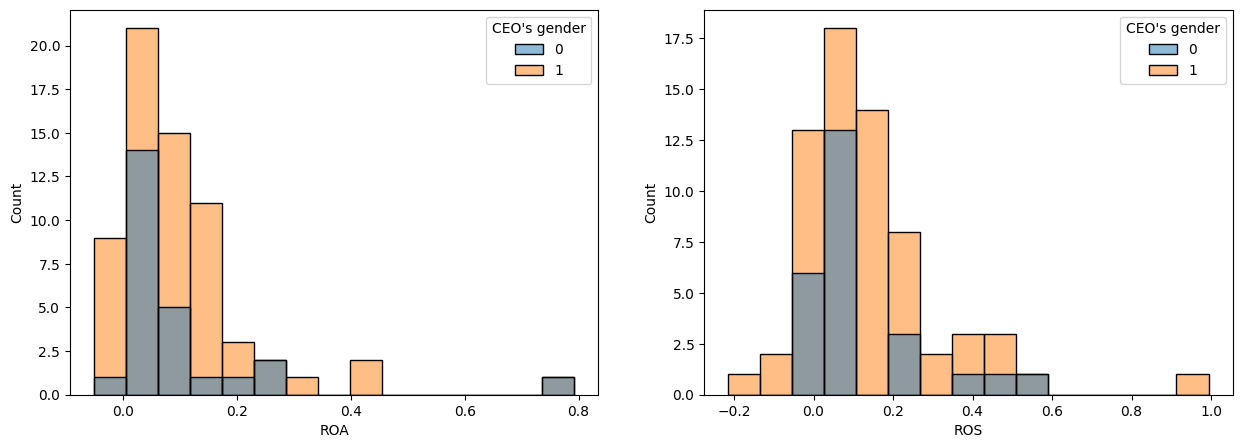

In [8]:
#Построим гистограмму распределния ROS и ROA в разрезе пола, чтобы проверить, действительно ли прослеживается связь.
#0 - CEO женщина, 1 - мужчина. Как видим из гистограммы, большинство значений сконцентрировались ближе к середине.
#к области медианных и средних значений за исключением отдельных выбросов. В абсолютном выражении все компании
#сконцентрировались в области от -0.2 до 0.2 для ROA и -0.5 до 0.5 для ROS. Явного полового перекоса в выбросах выше
#выше или ниже средних и медианных значений для общей выборки по рынку не наблюдается.

f, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.histplot(dfROA, x = "ROA", bins=15, hue= """CEO's gender""", ax=axes[0])
sns.histplot(dfROS, x = "ROS", bins=15, hue= """CEO's gender""",  ax=axes[1])

<Axes: >

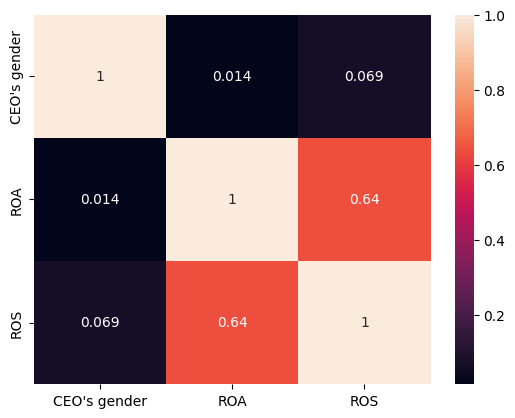

In [9]:
#Проведём последний тест корреляции между половым распределением и ROA/ROS. Как видим, корреляция фактически отсутствует.
#Мы не будем включать переменную пола в итоговое уравнение регрессии.

corrROA = dfROA[["CEO's gender", "ROA"]]
corrROS = dfROS[["ROS"]]
corr = pd.concat([corrROA,corrROS], axis = 1)
sns.heatmap(corr.corr(), annot=True)

###Анализ влияния национальности директора на финансовые показатели

In [10]:
#Посмотрим на средние и медианные значения финансовых показателей по рынку. Как видим, средние и медианные значения
# ROS и ROA у генеральных директоров-россиян выше, чем у иностранцев. Причём разница довольно значительна.


#Для ROS
df_for_analyze_ROA = dfROA[["CEO's nationality", "ROA"]].replace([0,1], ["Иностранец", "Русский"])
df_for_analyze_mean_ROA = df_for_analyze_ROA.groupby(["CEO's nationality"]).mean()
df_for_analyze_mean_ROA.round(2)
df_for_analyze_mean_ROA["ТИП"] = "Mean"

df_for_analyze_median_ROA = df_for_analyze_ROA.groupby(["CEO's nationality"]).median()
df_for_analyze_median_ROA.round(2)
df_for_analyze_median_ROA["ТИП"] = "Median"


#Аналогично для ROS
df_for_analyze_ROS = dfROS[["CEO's nationality", "ROS"]].replace([0,1], ["Иностранец", "Русский"])
df_for_analyze_mean_ROS = df_for_analyze_ROS.groupby(["CEO's nationality"]).mean()
df_for_analyze_mean_ROS.round(2)
df_for_analyze_mean_ROS["ТИП"] = "Mean"

df_for_analyze_median_ROS = df_for_analyze_ROS.groupby(["CEO's nationality"]).median()
df_for_analyze_median_ROS.round(2)
df_for_analyze_median_ROS["ТИП"] = "Median"


pd.concat([df_for_analyze_mean_ROA, df_for_analyze_median_ROA, df_for_analyze_mean_ROS, df_for_analyze_median_ROS], axis=1)

,ROA,ТИП,ROA,ТИП,ROS,ТИП,ROS,ТИП
CEO's nationality,,,,,,,,
Иностранец,0.026092,Mean,0.021442,Median,0.026791,Mean,0.011876,Median
Русский,0.111495,Mean,0.065074,Median,0.150351,Mean,0.093475,Median


<Axes: xlabel='ROS', ylabel='Count'>

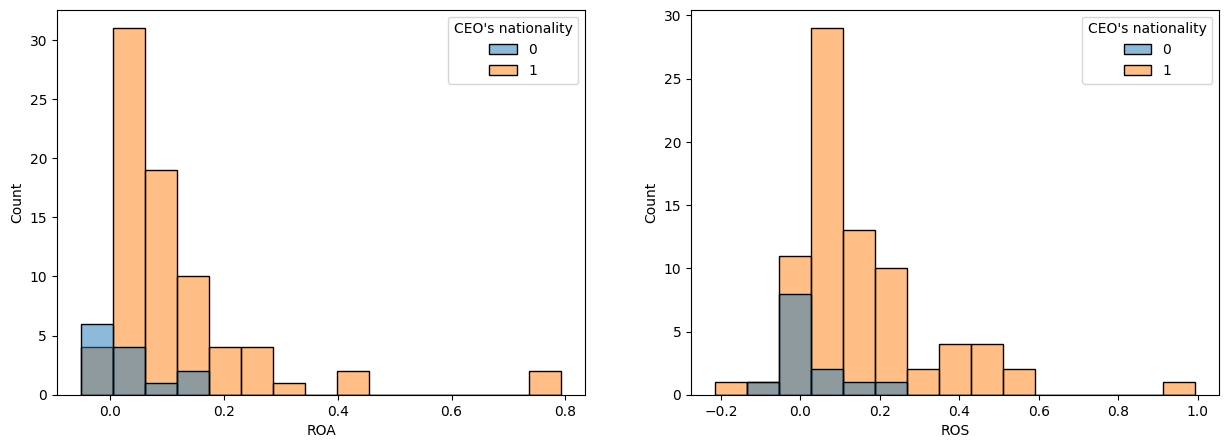

In [11]:
#Построим гистограмму распределния ROS и ROA в разрезе национальности, чтобы проверить, действительно ли прослеживается связь.
#0 - CEO россиянин, 1 - иностранец. Как видим из гистограммы, практически во всех группах ROA и ROS больше CEO-россиян.
#Это объясняется довольно просто - как правило генеральные директора в российских компаниях - это россияне, поэтому
#едва ли гистограмма поможет нам в проверке гипотезы о значимости переменной национальности. Тем не менее,
#даже в такой ситуации видно, что те компании, где генеральные директора иностранцы чаще превалируют в группах с ROS и ROA ниже
#среднего по рынку.


f, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.histplot(dfROA, x = "ROA", bins=15, hue= """CEO's nationality""", ax=axes[0])
sns.histplot(dfROS, x = "ROS", bins=15, hue= """CEO's nationality""",  ax=axes[1])

<Axes: >

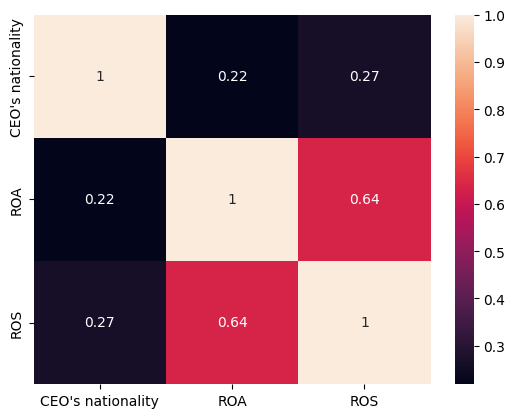

In [12]:
#Проведём последний тест корреляции между национальностью и ROA/ROS. Как видим, корреляция есть, хоть и слабая.
#На контрасте со значениями корреляции по полу эту переменную следует включить в уравнение регрессии и проверить её значимость
#На других тестах уже при работе с самим уравнением в будущем.

corrROA = dfROA[["CEO's nationality", "ROA"]]
corrROS = dfROS[["ROS"]]
corr = pd.concat([corrROA,corrROS], axis = 1)
sns.heatmap(corr.corr(), annot=True)

###Проверка влияния возраста директора на финансовые показатели

<Axes: >

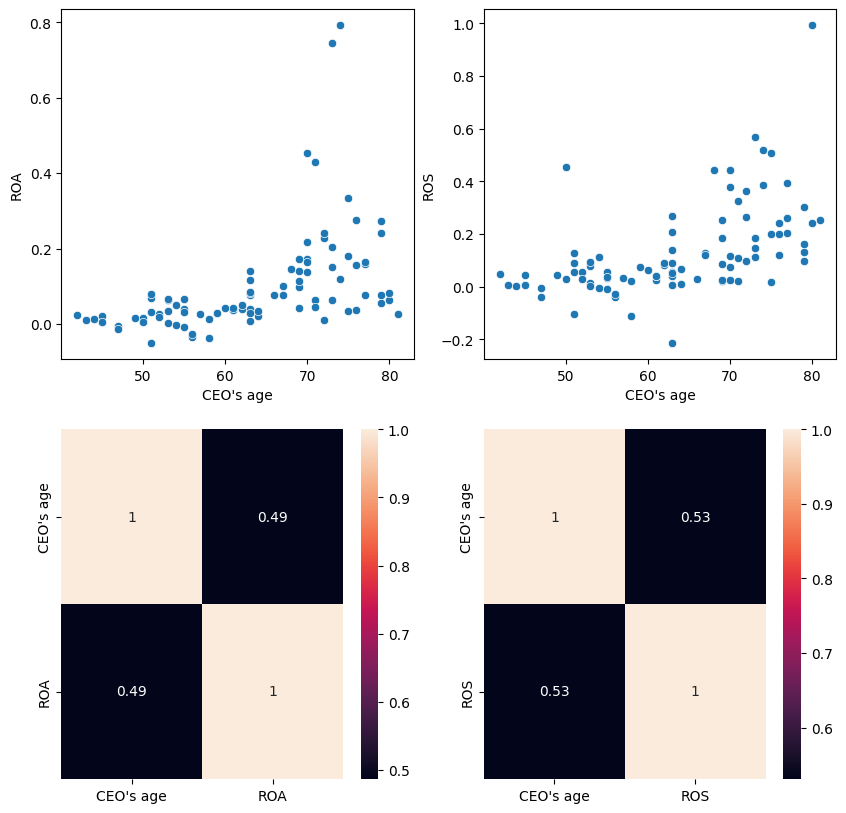

In [13]:
#Теперь построим диаграммы рассеивания на основе полученных данных. Как видим, наблюдается довольно очевидная прямая зависимость
#Чем выше возраст директора, тем лучшие финансовые показатели у фирмы. Подтвердим нашу гипотезу также корреляционным анализом.
#Что и требовалось ожидать - есть среднеумеренная связь между показателями возраста директора и финансовыми результатами.


f, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.scatterplot(dfROA[["CEO's age", "ROA"]], x = "CEO's age", y = "ROA", ax=axes[0,0])
sns.scatterplot(dfROS[["CEO's age", "ROS"]], x = "CEO's age", y = "ROS",ax=axes[0,1])

sns.heatmap(dfROA[["CEO's age", "ROA"]].corr(), annot=True, ax=axes[1,0])
sns.heatmap(dfROS[["CEO's age", "ROS"]].corr(), annot=True, ax=axes[1,1])




###Проверка влияния уровня образования директора на финансовые результаты компании

<Axes: >

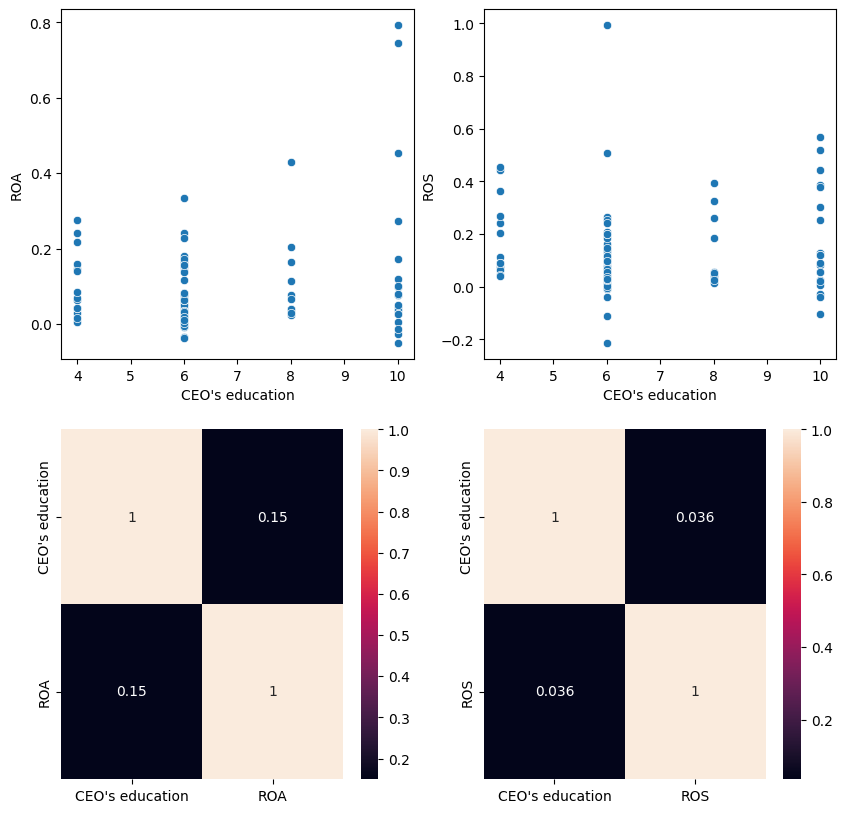

In [14]:
#Построим диаграммы рассеивания и корреляционные матрицы уровня образования. Обе диаграммы показали довольно хаотичную связь:
#нельзя точно увидеть какой-то тренд между уровнем образования и финансовыми показателями. При этом корреляционный анализ
#Тоже дал неоднозначные результаты - между уровнем образования и ROA наблюдается слабая связь со стремлением к средней.
#В то же время между ROS и уровнем образования связь не наблюдается вообще. Возможно, связь между ROA и уровнем образования
#можно объяснить тем, что директоров с несколькими высшими (8 - 10 лет обучения) чаще берут на работу именно крупные компании
#и назначают на высокие должности. Но при этом не факт, что такие директора будут генерировать прибыль, что объясняет
#отсутствие связи между образованием и ROS. Не будем включать эту переменную в уравнение регрессии.

f, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.scatterplot(dfROA[["CEO's education", "ROA"]], x = "CEO's education", y = "ROA", ax=axes[0,0])
sns.scatterplot(dfROS[["CEO's education", "ROS"]], x = "CEO's education", y = "ROS",ax=axes[0,1])

sns.heatmap(dfROA[["CEO's education", "ROA"]].corr(), annot=True, ax=axes[1,0])
sns.heatmap(dfROS[["CEO's education", "ROS"]].corr(), annot=True, ax=axes[1,1])




В результате анализа переменных мы обнаружили две потенциально влияющие переменные - возраст и национальность генерального директора. При этом в статистике остались еще переменные, которые могут повлиять на финансовые результаты компании.
Построим корреляционные матрицы по оставшимся данным и отберем те, где будет наблюдаться хотя бы слабая связь (больше 0.15 по шкале Чеддока) между влияющими и зависимыми переменными. Но перед этим сгладим данные методом кубического корня с целью уменьшить экспрессию переменных.

<Axes: >

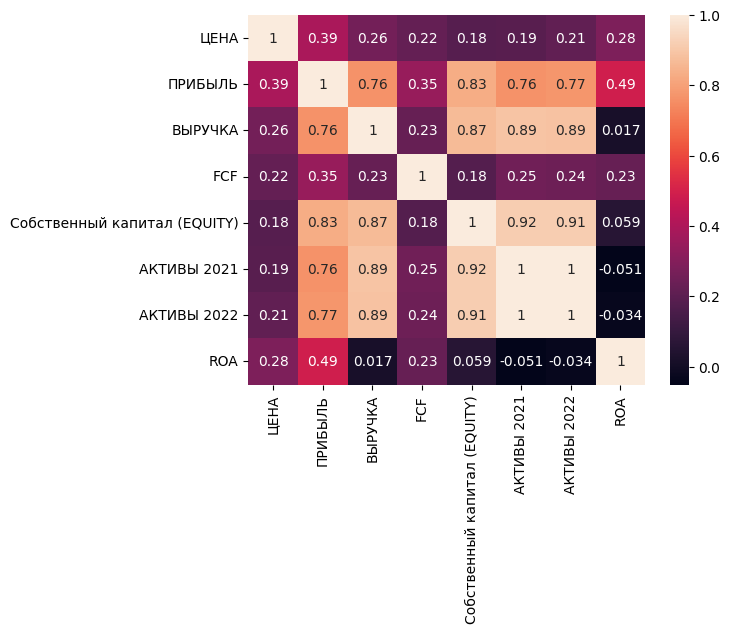

In [15]:

#Отбираем данные, которые нужно нормализовать и для которых нужно проверить корреляцию с целевыми переменными. 
dfNormROA = dfROA.loc[:, ~dfROA.columns.isin(['TICKER'])]
#Сглаживаем данные с помощью логарифма
dfNormROA = np.cbrt(dfNormROA)

#Отбрасываем лишние для матрицы столбцы
corrROS= dfNormROA.loc[:, ~dfNormROA.columns.isin(["CEO's gender", "CEO's age", "CEO's nationality", "CEO's education"])]
sns.heatmap(corrROS.corr(), annot=True)

<Axes: >

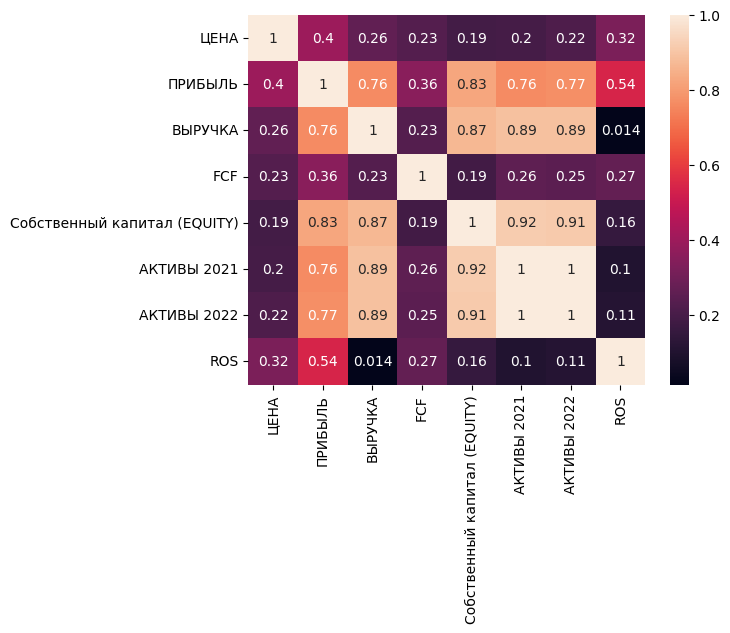

In [16]:
#Отбираем данные, которые нужно нормализовать и для которых нужно проверить корреляцию с целевыми переменными. 
dfNormROS = dfROS.loc[:, ~dfROS.columns.isin(['TICKER'])]
#Сглаживаем данные с помощью логарифма
dfNormROS = np.cbrt(dfNormROS)

#Отбрасываем лишние для матрицы столбцы
corrROS= dfNormROS.loc[:, ~dfNormROS.columns.isin(["CEO's gender", "CEO's age", "CEO's nationality", "CEO's education"])]
sns.heatmap(corrROS.corr(), annot=True)

Итого мы получили уравнения регрессии для прогнозирования ROA и ROS:

ROA = a0 + a1 * Цена + a2 * ПРИБЫЛЬ + a3 * FCF + a4 * CEO's age + a5 * CEO's nationality + error

ROS = b0 + b1 * Цена + b2 * ПРИБЫЛЬ + b3 * FCF + b4 * Equity + b5 * Чистые активы + b6 * CEO's age + b7 * CEO's nationality + error

In [17]:
#Перейдём к построению моделей. Для этого импортируем эконометрические библиотеки и подготовим датафрейм на нормализованных данных

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy



К сожалению, библиотека statsmodels имеет не все стандартные тесты, которые можно провести вызовом одной команды - для некоторых проверок необходима дополнительная ручная доработка. 

Так как мы будем проверять два уравнения регрессии, хотелось бы оптимизировать этот процесс с помощью инструмента, который будет принимать на вход вектор зависимой переменной и матрицу регрессоров и автоматически проводить все нужные нам тесты. С этой целью мы поверх стандартной библиотеки statsmodels создадим класс olsRegression, принимающий на вход x и y.

Затем от него унаследуем еще три класса: errorsTests, HausMarkovCheck и adequatCheck. Они так же будут принимать на вход x и y.

Класс olsRegression будет содержать следующие подклассы (блоки) методов:

- Класс errorsTests - отвечает за проверку модели на основные ошибки при разработке спецификации
- Класс HausMarkovCheck - отвечает за проверку модели на предпосылки теоремы Гауса-Маркова
- Класс adequatCheck - отвечает за проверку адекватности модели

In [18]:
class olsRegression:

    def __init__(self, y, x):
            self.y = y #целевая переменная
            self.x = x #матрица регрессоров
            #Результаты модели
            self.results = sm.OLS(self.y, self.x).fit()

class errorsTests(olsRegression):

    def importanceTest(self, alfa):
        results = self.results
        importantVars = pd.DataFrame(abs(results.params/results.bse), columns=["t"])
        importantVars["t_crit"] = scipy.stats.t.ppf(1-alfa/2, results.df_resid)
        importantVars["Important?"] = importantVars["t"] > importantVars["t_crit"]
        return importantVars

    def residualsTest(self): #Проверка случайности остатков модели
        results = self.results
        y = self.y
        x = self.x
        #Первым в датафрейм идёт массив значений целевой переменной y. Название столбца y присваивается в переменную main_var
        residuals_test = pd.DataFrame(y)
        main_var = residuals_test.columns[0]

            #Так как мы потенциально не знаем состав столбцов матрицы регрессоров x, мы используем цикл, чтобы мманипулировать ими.
            #Так, в датафрейм мы с помощью цикла загоняем столбец матрицы x и коэффициент этого столбца, а затем это значение отнимаем
            #от целевой переменной до тех пор, пока регрессоры не кончатся. Первоначально столбец residuals будет равен целевой переменной
            #и по мере цикла это значение будет переприсваиваться 
        residuals_test["residuals"] = residuals_test[main_var]

        for col in x.columns:
            residuals_test[col] = x[col]
            residuals_test[f"coef {col}"] = results.params[col]
            residuals_test["residuals"] = residuals_test["residuals"] - residuals_test[col]*residuals_test[f"coef {col}"]

                #Переносим столбец остатков в конец для удобства
        errors = residuals_test["residuals"]
        residuals_test = residuals_test.drop("residuals", axis = 1)
        residuals_test["residuals"] = errors

                #Суммируем регрессоры и сортируем по ним
        residuals_test["Regressors_Modules"] = abs(x.drop(["const"], axis = 1).sum(axis = 1))
        residualsChecking = residuals_test.sort_values(by = "Regressors_Modules")
        return residualsChecking
        
    def halfsTest(self):
        y = self.y
        x = self.x

        y_first_half = y[0 : int(len(y)/2)]
        x_first_half = x[0 : int(len(y)/2)]

        y_second_half = y[int(len(y)/2) : int(len(y))]
        x_second_half = x[int(len(y)/2) : int(len(y))]

        results_first_half = sm.OLS(y_first_half, x_first_half).fit()
        results_second_half = sm.OLS(y_second_half, x_second_half).fit()

        halfsComparison = pd.concat([results_first_half.params, results_second_half.params], axis = 1).rename(columns={0: "1st half", 1: "2nd half"})
        return halfsComparison
        
class HausMarkovCheck(olsRegression):
            
    def olsLearnData(self, controln): #Фунция построения модели

        y_Learn = self.y[controln : ]
        x_Learn = self.x[controln : ]
        results_Learn = sm.OLS(y_Learn, x_Learn).fit()
        return results_Learn.summary()

        #Проведение F-теста
    def Ftest(self, alfa, controln):
        y_Learn = self.y[controln : ]
        x_Learn = self.x[controln : ]
        results = sm.OLS(y_Learn, x_Learn).fit()

        f_crit = scipy.stats.f.ppf(q=1-alfa, dfn=len(results.params), dfd=len(y_Learn) - len(results.params))
        fvalue = results.fvalue
            
        fTest = pd.DataFrame({"F-value": [fvalue], "F-критическое": [f_crit]})
        fTest["Результат"] = fTest["F-value"]>fTest["F-критическое"]
        return fTest
        
    def gqTest(self, controln, dropValue):

        y_Learn = self.y[controln : ]
        x_Learn = self.x[controln : ]

        #Тест Готфрида-Квандта
        gq = sm.stats.diagnostic.het_goldfeldquandt(y_Learn, x_Learn, drop=dropValue)
        gq = "p-value gq равно " + str(gq[1])
        return gq
        
    def dwTest(self, controln):    
        from statsmodels.stats.stattools import durbin_watson
        y_Learn = self.y[controln : ]
        x_Learn = self.x[controln : ]
        results = sm.OLS(y_Learn, x_Learn).fit()
        dw = durbin_watson(results.resid)
        dw = "Статистика DW равна " + str(dw)
        return dw
        
class adequatCheck(olsRegression):

    def adequat_test(self, alfa, controln):
    #q0 = xT*(XT*X)**-1*x
        y_Learn = self.y[controln : ]
        x_Learn = self.x[controln : ]
        results = sm.OLS(y_Learn, x_Learn).fit()
            
        x_controln = self.x[0 : controln]
        y_controln = self.y[0 : controln]

        x = x_controln.transpose()
        XT = x_Learn.transpose()
        X = x_Learn
        xT = x_controln
        q = np.dot(
                np.dot(xT,
                    np.linalg.inv(
                            np.dot(XT,X))), x)[0][0]

        t_crit = scipy.stats.t.ppf(1-alfa/2, results.df_resid)
        S = np.std(results.resid)*(1+q)**0.5

        y_prognoz = results.predict(x_controln)
            

        yPredictions = pd.DataFrame()

        yPredictions["Фактические"] = y_controln
        yPredictions["y min"] = y_prognoz-S*t_crit
        yPredictions["y max"] = y_prognoz+S*t_crit

        return yPredictions

        



####ROA

Приступим к анализу. Сперва будем рассматривать уравнение регрессии ROA. Затем ROS. При этом будем строить сперва уравнение с контрольными переменными (только национальность и возраст), а затем сравним его с уравнением с добавлением вспомогательных переменных

Первым делом обозначим переменные и построим уравнение регрессии. Вспомним, что итого мы получили уравнения регрессии для прогнозирования ROA и ROS:

ROA = a0 + a1 * Цена + a2 * ПРИБЫЛЬ + a3 * FCF + a4 * CEO's age + a5 * CEO's nationality + error

ROS = b0 + b1 * Цена + b2 * ПРИБЫЛЬ + b3 * FCF + b4 * Equity + b5 * CEO's age + b6 * CEO's nationality + error

In [19]:
#Регрессия с основными переменными (ROA)

y = dfNormROA["ROA"]
x = dfNormROA[["CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

sm.OLS(y, x).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     35.14
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           6.51e-12
Time:                        11:36:35   Log-Likelihood:                 25.239
No. Observations:                  90   AIC:                            -44.48
Df Residuals:                      87   BIC:                            -36.98
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.1214      0.351     -6.036      0.000      -2.820      -1.423
CEO's age             0.5762      0.090      6.409      0.000       0.398       0.755
CEO's nationality     0.2251      0.057      3.949      0.000       0.112       0.338
==============================================================================
Omnibus:                       12.098   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.846
Skew:                          -0.637   Prob(JB):                     0.000362
Kurtosis:                       4.613   Cond. No.                         77.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
#Регрессия со вспомогательными переменными

y = dfNormROA["ROA"]
x = dfNormROA[["ЦЕНА", "ПРИБЫЛЬ", "FCF", "CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     20.72
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           2.00e-13
Time:                        11:36:35   Log-Likelihood:                 34.749
No. Observations:                  90   AIC:                            -57.50
Df Residuals:                      84   BIC:                            -42.50
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8735      0.330     -5.670      0.000      -2.531      -1.216
ЦЕНА                  0.0036      0.004      0.996      0.322      -0.004       0.011
ПРИБЫЛЬ            4.078e-05   1.15e-05      3.538      0.001    1.79e-05    6.37e-05
FCF               -6.035e-07   8.23e-06     -0.073      0.942    -1.7e-05    1.58e-05
CEO's age             0.4985      0.085      5.845      0.000       0.329       0.668
CEO's nationality     0.1892      0.053      3.558      0.001       0.083       0.295
==============================================================================
Omnibus:                        5.054   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                6.098
Skew:                          -0.211   Prob(JB):                       0.0474
Kurtosis:                       4.203   Cond. No.                     5.68e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Посмотрим на результаты расчётов.

Adj. R-squared получился 0.526 , что, в целом, неплохо, однако нужно провести ряд статистических тестов, чтобы в случае необходимости улучшить модель.

Первым делом проведём проверку на ОСНОВНЫЕ ОШИБКИ СПЕЦИФИКАЦИИ, а именно:

- Включение незначащих переменных в модель
- Неверно выбранная функция модели
- Невключение важных регрессоров в модель

###ВКЛЮЧЕНИЕ НЕЗНАЧАЩИХ ПЕРЕМЕННЫХ

Коэффициент t показывает отношение оценённого коэффициента к среднеквадратической ошибке и с помощью него можно проверить модель на ошибку второго типа, а именно включение незначащих регрессоров в модель. Так, если модуль коэффициента t окажется больше t критического, значит регрессор считается значимым. В противном случае регрессор стоит убрать из модели.
	
Чтобы узнать значение t-распределения используем библиотеку scipy и модуль t.ppf, в котором нам необходимо указать два значения: критический уровень и степень свободы. Критический уровень alfa мы примем за 0.05, степень свободы по нашей модели равна 80. В целом, все эти условия заложены в класс errorsTests, мы лишь подаём на вход y,x и критический уровень 

Итого, t-критическое = 1.98861.


In [21]:
#Важными оказались переменные Прибыль, возраст и национальность. Исключим лишние переменные и повторим тест
errorsTests(y,x).importanceTest(0.05)

,t,t_crit,Important?
const,5.669721,1.98861,True
ЦЕНА,0.995575,1.98861,False
ПРИБЫЛЬ,3.538412,1.98861,True
FCF,0.073353,1.98861,False
CEO's age,5.845278,1.98861,True
CEO's nationality,3.558212,1.98861,True


In [22]:
y = dfNormROA["ROA"]
x = dfNormROA[["ПРИБЫЛЬ", "CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)


sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     34.61
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           9.13e-15
Time:                        11:36:35   Log-Likelihood:                 34.222
No. Observations:                  90   AIC:                            -60.44
Df Residuals:                      86   BIC:                            -50.44
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8840      0.325     -5.805      0.000      -2.529      -1.239
ПРИБЫЛЬ            4.466e-05   1.02e-05      4.359      0.000    2.43e-05     6.5e-05
CEO's age             0.5061      0.083      6.067      0.000       0.340       0.672
CEO's nationality     0.1857      0.053      3.525      0.001       0.081       0.290
==============================================================================
Omnibus:                        5.651   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                6.769
Skew:                          -0.273   Prob(JB):                       0.0339
Kurtosis:                       4.227   Cond. No.                     4.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
#Теперь все переменные значимы
errorsTests(y,x).importanceTest(0.05)

,t,t_crit,Important?
const,5.805275,1.987934,True
ПРИБЫЛЬ,4.358834,1.987934,True
CEO's age,6.067195,1.987934,True
CEO's nationality,3.524986,1.987934,True


##ПРОВЕРКА НА ПРАВИЛЬНО ПОДОБРАННУЮ ФУНКЦИЮ РЕГРЕССИИ

Для этого нам нужно оценить коэффициенты двух моделей из разбитыХ поровну выборок.
	
Оценим коэффициенты двух моделей. Разделим выборку.

Как мы видим, оценки коэффициентов мало отличаются друг от друга при разделении выборок на две равные части
(не более чем на 15%)

#НИКИТА ПРОВЕРЬ!!!!!!!!!!!!!!!!!!!!1

In [24]:
errorsTests(y,x).halfsTest()

,1st half,2nd half
const,-1.996474,-1.565386
ПРИБЫЛЬ,0.000020,0.000088
CEO's age,0.509478,0.430357
CEO's nationality,0.357724,0.065734


###Невключение важных регрессоров в модель

Для этого нам нужно оценить знаки случайных остатков.
	
Расположим модули регрессоров по возрастанию и посмотрим на знаки. В целом знаки остатков не задерживаются на одном месте и постоянно меняются. Можем говорить о том, что остатки действительно случайные.

На этапе проверки удовлетворения теореме Гаусса Маркова мы так же проведем тест Дарбина Уотсона


In [25]:
#Остатки случайные, значит все важные переменные были включены.

#errorsTests(y,x).residualsTest()

Тестирование адекватности предпосылок теоремы Гаусса-Маркова и оценка параметров модели

После проверки на основные симптомы некачественной модели, мы убедились, что явных признаков плохой спецификации нет. Теперь перейдем к тестированию предпосылок Гаусса-Маркова, а именно:

1.	Математическое ожидание случайных остатков равно нулю. 
H0: E(ui) = 0
2.	Предпосылка о постоянстве дисперсии случайных остатков во всех наблюдениях.
H0: Var(ui) = sigma^2
3.	Отсутствие корреляции между случайными остатками в любом наблюдении:
H0: Cov(ui, un) = 0


Первым делом разделим датафрейм на две выборки – обучающую и контролирующую. Пусть значения с пятого по последнее будут в обучающей выборке. С первого по пятое значения мы затем проверим адекватность модели.

Для проверки первой предпосылки мы должны провести F-тест.

In [26]:

y = dfNormROA["ROA"]
x = dfNormROA[["ПРИБЫЛЬ", "CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

HausMarkovCheck(y,x).Ftest(alfa = 0.05, controln = 5)

,F-value,F-критическое,Результат
0,31.71804,2.484441,True


Тестирование адекватности предпосылок теоремы Гаусса-Маркова и оценка параметров модели

После проверки на основные симптомы некачественной модели, мы убедились, что явных признаков плохой спецификации нет. Теперь перейдем к тестированию предпосылок Гаусса-Маркова, а именно:

1.	Математическое ожидание случайных остатков равно нулю. 
H0: E(ui) = 0
2.	Предпосылка о постоянстве дисперсии случайных остатков во всех наблюдениях.
H0: Var(ui) = sigma^2
3.	Отсутствие корреляции между случайными остатками в любом наблюдении:
H0: Cov(ui, un) = 0


Первым делом разделим датафрейм на две выборки – обучающую и контролирующую. Пусть значения с пятого по последнее будут в обучающей выборке. С первого по пятое значения мы затем проверим адекватность модели.

Для проверки первой предпосылки мы должны провести F-тест.

In [27]:

y = dfNormROA["ROA"]
x = dfNormROA[["ПРИБЫЛЬ", "CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

HausMarkovCheck(y,x).Ftest(alfa = 0.05, controln = 15)

,F-value,F-критическое,Результат
0,27.310316,2.50076,True


In [28]:
sm.OLS(y[5:], x[5:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     31.72
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           1.16e-13
Time:                        11:36:35   Log-Likelihood:                 30.438
No. Observations:                  85   AIC:                            -52.88
Df Residuals:                      81   BIC:                            -43.11
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8874      0.353     -5.347      0.000      -2.590      -1.185
ПРИБЫЛЬ            4.377e-05   1.07e-05      4.101      0.000    2.25e-05     6.5e-05
CEO's age             0.5071      0.091      5.580      0.000       0.326       0.688
CEO's nationality     0.1837      0.054      3.377      0.001       0.075       0.292
==============================================================================
Omnibus:                        4.712   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                5.080
Skew:                          -0.250   Prob(JB):                       0.0789
Kurtosis:                       4.088   Cond. No.                     4.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

F-статистика больше F-критического при уровне значимости 5% и степенях свободы 4 и 86. Это значит, что мы принимаем гипотезу о нулевом математическом ожидании случайных остатков и можем доверять коэффициенту детерминации, который для данной модели равен 0,523. Спецификация признана качественной.

Для проверки второй предпосылки Гаусса-Маркова о гомоскедастичности случайных остаков обратимся к тесту Готфрида-Квандта. В библиотеке statsmodels он выполняется с помощью модуля het_goldfeldquandt(), входные данные для которого – это вектор статистики по эндогенной переменной и матрица статистики по экзогенным переменным. Третий параметр, который необходимо задать – это мера отсечения переменных из середины, чтобы потом алгоритм сравнил, как отличается распределение остатков по обе стороны от середины. Документация statsmodels рекомендует задавать этот параметр как 20% от выборки. 

НИКИТА ПРОВЕРЬ!!!!!!!!!!!!!

In [29]:
HausMarkovCheck(y,x).gqTest(controln=5, dropValue = 0.2)

'p-value gq равно 0.06322481994535777'

Суть теста заключается в проверке H0: Var(u1) = Var(u2) = Var(ui) = sigma^2. Если значения теста окажется меньше p-value в 5%, то мы отвергаем нулевую гипотезу. Если нет, то принимаем.

Тест показал значение равное 0.06 при отсечении 20% выборки. Мы принимаем гипотезу о гомоскедастичности случайных остатков.

----------

Для проверки третьей предпосылки теоремы Гауса-Маркова о неавтокорелированности случайных остатков (которую мы ранее частично провели) мы применим к обучающей выборке тест DW. Хорошим значением будет считаться расположение статистики DW в пределах от 1.5 до 2.5 Чем ближе к 2, тем меньше автокорреляция

In [30]:
HausMarkovCheck(y,x).dwTest(controln=5)

'Статистика DW равна 2.0832827234887605'

Значение попадает в установленные пределы. Остатки не автокоррелируют.

ПРОВЕРКА АДЕКВАТНОСТИ МОДЕЛИ
----

Для проверки адекватности модели мы должны составить доверительный интервал и узнать, попадает ли фактическое значение ROA в него или нет.


Для этого найдём коэффициент q по формуле q = xT*(XT*X)**-1*x.
Затем вычислим значение S, Y1 и границы доверительного интервала по формулам: 
S = sigma*√(1+q)

Y1 - прогнозное
Y1- = Y1 – S*tcrit
Y1+ = Y1 + S*tcrit

Все эти расчёты уже заложены в класс adequatCheck

НИКИТА ПРОВЕРЬ!!!!!!!!!!!!!!!!!!

In [31]:
adequatCheck(y,x).adequat_test(alfa = 0.05, controln=15)

,Фактические,y min,y max
0,0.230228,-0.070170,0.598935
1,0.424689,0.064409,0.733514
2,0.283329,-0.120337,0.548768
3,0.257480,-0.090584,0.578521
4,0.694209,0.188396,0.857501
6,0.906751,0.133021,0.802126
7,0.461632,0.120650,0.789755
8,0.400250,0.112554,0.781659
9,0.426972,0.137757,0.806862
10,0.424228,0.004999,0.674103


Как мы видим, фактические переменные попадают в доверительный интервал. Модель адекватна.

Аналогично строим модель ROS

ROS = b0 + b1 * Цена + b2 * ПРИБЫЛЬ + b3 * FCF + b4 * Equity + b5 * CEO's age + b6 * CEO's nationality + error

In [32]:
#Регрессия с основными переменными (ROA)

y = dfNormROS["ROS"]
x = dfNormROS[["CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

sm.OLS(y, x).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROS   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     27.59
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           5.00e-10
Time:                        11:36:35   Log-Likelihood:                 2.9580
No. Observations:                  91   AIC:                           0.08391
Df Residuals:                      88   BIC:                             7.616
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.3674      0.450     -5.258      0.000      -3.262      -1.473
CEO's age             0.6354      0.115      5.516      0.000       0.406       0.864
CEO's nationality     0.2711      0.073      3.716      0.000       0.126       0.416
==============================================================================
Omnibus:                       35.245   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.217
Skew:                          -1.272   Prob(JB):                     2.34e-23
Kurtosis:                       7.584   Cond. No.                         78.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
y = dfNormROS["ROS"]
x = dfNormROS[["ЦЕНА", "ПРИБЫЛЬ", "FCF", "Собственный капитал (EQUITY)", "CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROS   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     24.45
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           1.46e-16
Time:                        11:36:35   Log-Likelihood:                 26.784
No. Observations:                  91   AIC:                            -39.57
Df Residuals:                      84   BIC:                            -21.99
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.0712      0.414     -2.589      0.011      -1.894      -0.248
ЦЕНА                             0.0007      0.004      0.170      0.866      -0.008       0.009
ПРИБЫЛЬ                          0.0002   2.59e-05      6.228      0.000       0.000       0.000
FCF                          -3.213e-06   9.16e-06     -0.351      0.727   -2.14e-05     1.5e-05
Собственный капитал (EQUITY) -6.358e-05   1.38e-05     -4.594      0.000   -9.11e-05   -3.61e-05
CEO's age                        0.3202      0.103      3.112      0.003       0.116       0.525
CEO's nationality                0.1610      0.060      2.682      0.009       0.042       0.280
==============================================================================
Omnibus:                       14.987   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.366
Skew:                          -0.692   Prob(JB):                     8.43e-06
Kurtosis:                       5.060   Cond. No.                     1.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Посмотрим на результаты расчётов.

Adj. R-squared получился 0.846 , что, в целом, неплохо, однако нужно провести ряд статистических тестов, чтобы в случае необходимости улучшить модель.

Первым делом проведём проверку на ОСНОВНЫЕ ОШИБКИ СПЕЦИФИКАЦИИ, а именно:

- Включение незначащих переменных в модель
- Неверно выбранная функция модели
- Невключение важных регрессоров в модель
###ВКЛЮЧЕНИЕ НЕЗНАЧАЩИХ ПЕРЕМЕННЫХ
Коэффициент t показывает отношение оценённого коэффициента к среднеквадратической ошибке и с помощью него можно проверить модель на ошибку второго типа, а именно включение незначащих регрессоров в модель. Так, если модуль коэффициента t окажется больше t критического, значит регрессор считается значимым. В противном случае регрессор стоит убрать из модели.
	
Чтобы узнать значение t-распределения используем библиотеку scipy и модуль t.ppf, в котором нам необходимо указать два значения: критический уровень и степень свободы. Критический уровень alfa мы примем за 0.05, степень свободы по нашей модели равна 80. В целом, все эти условия заложены в класс errorsTests, мы лишь подаём на вход y,x и критический уровень 

Итого, t-критическое = 1.98861.


In [34]:
#Важными оказались все переменные кроме цены и FCF. Исключим лишние переменные и повторим тест
errorsTests(y,x).importanceTest(0.05)

,t,t_crit,Important?
const,2.588885,1.98861,True
ЦЕНА,0.169542,1.98861,False
ПРИБЫЛЬ,6.227643,1.98861,True
FCF,0.350687,1.98861,False
Собственный капитал (EQUITY),4.594326,1.98861,True
CEO's age,3.111601,1.98861,True
CEO's nationality,2.681541,1.98861,True


In [35]:
y = dfNormROS["ROS"]
x = dfNormROS[["ПРИБЫЛЬ", "Собственный капитал (EQUITY)", "CEO's age", "CEO's nationality"]]
x = sm.add_constant(x)

sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROS   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     37.45
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           4.13e-18
Time:                        11:36:35   Log-Likelihood:                 26.704
No. Observations:                  91   AIC:                            -43.41
Df Residuals:                      86   BIC:                            -30.85
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.0563      0.406     -2.599      0.011      -1.864      -0.248
ПРИБЫЛЬ                          0.0002   2.23e-05      7.173      0.000       0.000       0.000
Собственный капитал (EQUITY) -6.346e-05    1.3e-05     -4.887      0.000   -8.93e-05   -3.76e-05
CEO's age                        0.3170      0.101      3.125      0.002       0.115       0.519
CEO's nationality                0.1616      0.059      2.754      0.007       0.045       0.278
==============================================================================
Omnibus:                       14.883   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.825
Skew:                          -0.695   Prob(JB):                     1.11e-05
Kurtosis:                       5.021   Cond. No.                     1.10e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
#Теперь все переменные значимы
errorsTests(y,x).importanceTest(0.05)

,t,t_crit,Important?
const,2.598744,1.987934,True
ПРИБЫЛЬ,7.173254,1.987934,True
Собственный капитал (EQUITY),4.886713,1.987934,True
CEO's age,3.124747,1.987934,True
CEO's nationality,2.754357,1.987934,True


##ПРОВЕРКА НА ПРАВИЛЬНО ПОДОБРАННУЮ ФУНКЦИЮ РЕГРЕССИИ

Для этого нам нужно оценить коэффициенты двух моделей из разбитыХ поровну выборок.
	
Оценим коэффициенты двух моделей. Разделим выборку.

Как мы видим, оценки коэффициентов мало отличаются друг от друга при разделении выборок на две равные части
(не более чем на 15%)

In [37]:
errorsTests(y,x).halfsTest()

,1st half,2nd half
const,-1.158159,-1.375593
ПРИБЫЛЬ,0.000154,0.000176
Собственный капитал (EQUITY),-0.000060,-0.000074
CEO's age,0.281201,0.426617
CEO's nationality,0.414360,0.038985


###Невключение важных регрессоров в модель

Для этого нам нужно оценить знаки случайных остатков.
	
Расположим модули регрессоров по возрастанию и посмотрим на знаки. В целом знаки остатков не задерживаются на одном месте и постоянно меняются. Можем говорить о том, что остатки действительно случайные.

На этапе проверки удовлетворения теореме Гаусса Маркова мы так же проведем тест Дарбина Уотсона


In [38]:
#Остатки случайные, значит все важные переменные были включены.

errorsTests(y,x).residualsTest()
reportResiduals = errorsTests(y,x).residualsTest()

Тестирование адекватности предпосылок теоремы Гаусса-Маркова и оценка параметров модели
После проверки на основные симптомы некачественной модели, мы убедились, что явных признаков плохой спецификации нет. Теперь перейдем к тестированию предпосылок Гаусса-Маркова, а именно:

1.	Математическое ожидание случайных остатков равно нулю. 
H0: E(ui) = 0
2.	Предпосылка о постоянстве дисперсии случайных остатков во всех наблюдениях.
H0: Var(ui) = sigma^2
3.	Отсутствие корреляции между случайными остатками в любом наблюдении:
H0: Cov(ui, un) = 0

Первым делом разделим датафрейм на две выборки – обучающую и контролирующую. Пусть значения с пятого по последнее будут в обучающей выборке. С первого по пятое значения мы затем проверим адекватность модели.
Для проверки первой предпосылки мы должны провести F-тест.


In [39]:
HausMarkovCheck(y,x).Ftest(alfa = 0.05, controln = 15)

,F-value,F-критическое,Результат
0,30.434715,2.34368,True


In [40]:
sm.OLS(y[5:], x[5:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROS   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     34.79
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           6.86e-17
Time:                        11:36:35   Log-Likelihood:                 23.505
No. Observations:                  86   AIC:                            -37.01
Df Residuals:                      81   BIC:                            -24.74
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.9947      0.443     -2.245      0.028      -1.876      -0.113
ПРИБЫЛЬ                          0.0002   2.34e-05      6.904      0.000       0.000       0.000
Собственный капитал (EQUITY) -6.405e-05   1.35e-05     -4.756      0.000   -9.08e-05   -3.73e-05
CEO's age                        0.3014      0.111      2.717      0.008       0.081       0.522
CEO's nationality                0.1599      0.060      2.649      0.010       0.040       0.280
==============================================================================
Omnibus:                       13.088   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.616
Skew:                          -0.661   Prob(JB):                     9.07e-05
Kurtosis:                       4.857   Cond. No.                     1.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

F-статистика больше F-критического при уровне значимости 5% и степенях свободы 4 и 86. Это значит, что мы принимаем гипотезу о нулевом математическом ожидании случайных остатков и можем доверять коэффициенту детерминации, который для данной модели равен 0,846. Спецификация признана качественной.


Для проверки второй предпосылки Гаусса-Маркова о гомоскедастичности случайных остаков обратимся к тесту Готфрида-Квандта. В библиотеке statsmodels он выполняется с помощью модуля het_goldfeldquandt(), входные данные для которого – это вектор статистики по эндогенной переменной и матрица статистики по экзогенным переменным. Третий параметр, который необходимо задать – это мера отсечения переменных из середины, чтобы потом алгоритм сравнил, как отличается распределение остатков по обе стороны от середины. Документация statsmodels рекомендует задавать этот параметр как 20% от выборки. 


НИКИТА ПРОВЕРЬ!!!!!!!!!!!!!


In [41]:
HausMarkovCheck(y,x).gqTest(controln=15, dropValue = 0.2)

'p-value gq равно 0.4359730805634595'

Суть теста заключается в проверке H0: Var(u1) = Var(u2) = Var(ui) = sigma^2. Если значения теста окажется меньше p-value в 5%, то мы отвергаем нулевую гипотезу. Если нет, то принимаем.

Тест показал значение равное 0.45 при отсечении 20% выборки. Мы принимаем гипотезу о гомоскедастичности случайных остатков.

----------

Для проверки третьей предпосылки теоремы Гауса-Маркова о неавтокорелированности случайных остатков (которую мы ранее частично провели) мы применим к обучающей выборке тест DW. Хорошим значением будет считаться расположение статистики DW в пределах от 1.5 до 2.5 Чем ближе к 2, тем меньше автокорреляция

In [42]:
HausMarkovCheck(y,x).dwTest(controln=15)

'Статистика DW равна 1.8953654832298854'

Значение попадает в установленные пределы. Остатки не автокоррелируют.

ПРОВЕРКА АДЕКВАТНОСТИ МОДЕЛИ
----

Для проверки адекватности модели мы должны составить доверительный интервал и узнать, попадает ли фактическое значение ROS в него или нет.


Для этого найдём коэффициент q по формуле q = xT*(XT*X)**-1*x.
Затем вычислим значение S, Y1 и границы доверительного интервала по формулам: 

S = sigma*√(1+q)

Y1 - прогнозное

Y1- = Y1 – S*tcrit

Y1+ = Y1 + S*tcrit

Все эти расчёты уже заложены в класс adequatCheck

НИКИТА ПРОВЕРЬ!!!!!!!!!!!!!!!!!!

In [43]:
adequatCheck(y,x).adequat_test(alfa = 0.05, controln=15)

,Фактические,y min,y max
0,0.272776,-0.056862,0.694696
1,0.504381,0.053354,0.804912
2,0.363450,0.037015,0.788573
3,0.304560,-0.141110,0.610448
4,0.797664,0.228956,0.980514
6,0.829036,0.202993,0.954551
7,0.442677,0.159275,0.910833
8,0.480733,0.080087,0.831645
9,0.639707,0.099177,0.850736
10,0.387242,-0.000601,0.750957


Как мы видим, фактические переменные попадают в доверительный интервал. Модель адекватна.

In [ ]:
#Сохраняем отчет для анализа

#create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter('Большие таблицы.xlsx', engine='xlsxwriter')

#write each DataFrame to a specific sheet
reportReview.to_excel (writer, sheet_name='Описательная статистика', index = False)
reportResiduals. to_excel (writer, sheet_name='Тест остатков', index = False)

#close the Pandas Excel writer and output the Excel file
writer.save()